# A simple experiment with the analytical queueing model

**Note: since performing some of the below experiments, a small mistake in how the avg_unshelted is calculated in the code was found and fixed, but these experiments have not been reconsidered yet - the details of the experiments will need to be reconsidered in order to illustrate the points made. **

In [1]:
import ranking_and_selection as rs
import queueing_model as qm
import json
import datetime
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Opening JSON file
with open('data_as_is.json') as json_file:
    data_as_is = json.load(json_file)
    
# Opening JSON file
with open('data_as_is_simulation.json') as json_file:
    data_as_is_simulation = json.load(json_file)
    
# Opening JSON file
with open('data_as_is_analytical.json') as json_file:
    data_as_is_analytical = json.load(json_file)

Here we perform a simple experiment in order to understand the effects of three different factors on the value of a simple objective function when we decide to build housing or shelter, and therefore our preference for housing or shelter. The three different factors are: 

* the point in time at which we add accommodation (housing or shelter)
* the relative cost of shelter compared to housing
* the rate at which customers are served in housing

We aim to isolate the effects of each of the three factors in order to gain this understanding. 

## Experiment setup

We start with the following 'as-is' parameters for the analytical model, which in part originate from the analytical counterpart of the simulation model of Singham et al. (2023) (i.e. the initial capacity, the time between changes in build rate and the time between building) but also include parameters which prove convenient for studying the behaviour of the queues (i.e. the initial demand, arrival rates and the analysis horizon). 

In [3]:
# Opening JSON file
with open('data_as_is_exp1.json') as json_file:
    data_as_is_exp1 = json.load(json_file)

In [4]:
print('Length of model run (yrs): ' + str(data_as_is_exp1['analysis_horizon']))
print('Initial capacity: ' + str(data_as_is_exp1['initial_capacity']))
print('Initial demand: ' + str(data_as_is_exp1['initial_demand']))
for i in range(len(data_as_is_exp1['arrival_rates'])):
    print('Arrival rates yr ' + str(i+1) + ': ' + str(data_as_is_exp1['arrival_rates'][i]))
print('Time between changes in the build rate (weeks): ' + str(int(data_as_is_exp1['time_btwn_changes_in_build_rate']*365/7)))
print('Time between building (weeks): ' + str(int(data_as_is_exp1['time_btwn_building']*365/7)))

Length of model run (yrs): 4
Initial capacity: {'housing': 40, 'shelter': 15}
Initial demand: 180
Arrival rates yr 1: 100
Arrival rates yr 2: 100
Arrival rates yr 3: 100
Arrival rates yr 4: 100
Time between changes in the build rate (weeks): 54
Time between building (weeks): 9


The two parameters left out above which we want to experiment with are the service times and the build rates. The service time for shelter we always set as 0, and for the housing service time means we will look at a range (and a correpsponding range of housing service rates): 

In [5]:
service_times = [1,2,3,4,5]
print('Housing service time means - range to be studied (yrs): ' + str(service_times))
print('Housing service rates - range to be studied (1/yrs): ' + str([round(1/i,2) for i in service_times]))

Housing service time means - range to be studied (yrs): [1, 2, 3, 4, 5]
Housing service rates - range to be studied (1/yrs): [1.0, 0.5, 0.33, 0.25, 0.2]


For the build rates, we start with a baseline of building 12 extra housing and 12 extra shelter units every year, for 4 years: 

In [6]:
sol = [{'housing': [12, 12, 12, 12], 'shelter': [12, 12, 12, 12]}]
print(sol)

[{'housing': [12, 12, 12, 12], 'shelter': [12, 12, 12, 12]}]


This gives us the following objective function values, with a simple objective function of the expected value of the time-averaged unsheltered queue: 

In [7]:
out = []
for i in range(len(service_times)):
    spc = rs.SolutionSpace(sol)
    spc.model_analytically(data_as_is_exp1, data_as_is_analytical, data_as_is_exp1['analysis_horizon'], float(service_times[i]))
    out.append(spc.true_outputs_unsh[0])

In [8]:
for i in range(len(out)):
    print('Service rate: ' + str(round(1/service_times[4-i],2)) + ', Obj value: ' + str(round(out[4-i],2)))

Service rate: 0.2, Obj value: 252.01
Service rate: 0.25, Obj value: 247.19
Service rate: 0.33, Obj value: 238.49
Service rate: 0.5, Obj value: 219.92
Service rate: 1.0, Obj value: 163.6


We then experiment with adding to our baseline build rate in 8 different ways - adding extra shelter or adding extra housing in one of each of the four years. For this extra accommodation, we have budget equivalent to 60 houses. If we choose to spend that on housing then in one of four years we can build 60 extra houses. If we decide to add extra shelter in a particular year, then the amount of extra shelter units which we add depends on the cost of a shelter unit compared to housing. This cost we range from 1 to 0.25:

In [9]:
hx = 60 # base amount of extra accomm
additional_shelter = [hx + i*6 for i in range(31)]
print('Cost of shelter (as proportion of cost of housing) - range to be studied: ' + str([round(hx/i,2) for i in additional_shelter]))

Cost of shelter (as proportion of cost of housing) - range to be studied: [1.0, 0.91, 0.83, 0.77, 0.71, 0.67, 0.62, 0.59, 0.56, 0.53, 0.5, 0.48, 0.45, 0.43, 0.42, 0.4, 0.38, 0.37, 0.36, 0.34, 0.33, 0.32, 0.31, 0.3, 0.29, 0.29, 0.28, 0.27, 0.26, 0.26, 0.25]


The effect of these costs is that if we add extra shelter units in a particular year, the amount that we add falls in the following range: 

In [10]:
print('The amount of additional shelter we may build: ' + str(additional_shelter))

The amount of additional shelter we may build: [60, 66, 72, 78, 84, 90, 96, 102, 108, 114, 120, 126, 132, 138, 144, 150, 156, 162, 168, 174, 180, 186, 192, 198, 204, 210, 216, 222, 228, 234, 240]


In summary: for every combination of 'housing service rate' and 'cost of shelter units', we model 8 different solutions with the build rates given below, where 'bx' is the amount of extra housing we can afford (60 units) and 'sx' depends on the cost of shelter. And for all of these solutions, the dynamics of the model run depends on the 'housing service rate' which we are using. These 8 solutions effectively amount to adding either extra shelter or extra housing in one of each of the four years. 

In [11]:
sols = [{'housing': ['12+bx', 12, 12, 12], 'shelter': [12, 12, 12, 12]},
        {'housing': [12, '12+bx', 12, 12], 'shelter': [12, 12, 12, 12]},
        {'housing': [12, 12, '12+bx', 12], 'shelter': [12, 12, 12, 12]},
        {'housing': [12, 12, 12, '12+bx'], 'shelter': [12, 12, 12, 12]},
        {'housing': [12, 12, 12, 12], 'shelter': ['12+sx', 12, 12, 12]},
        {'housing': [12, 12, 12, 12], 'shelter': [12, '12+sx', 12, 12]},
        {'housing': [12, 12, 12, 12], 'shelter': [12, 12, '12+sx', 12]},
        {'housing': [12, 12, 12, 12], 'shelter': [12, 12, 12, '12+sx']}]
for i in range(len(sols)):
    print(sols[i])

{'housing': ['12+bx', 12, 12, 12], 'shelter': [12, 12, 12, 12]}
{'housing': [12, '12+bx', 12, 12], 'shelter': [12, 12, 12, 12]}
{'housing': [12, 12, '12+bx', 12], 'shelter': [12, 12, 12, 12]}
{'housing': [12, 12, 12, '12+bx'], 'shelter': [12, 12, 12, 12]}
{'housing': [12, 12, 12, 12], 'shelter': ['12+sx', 12, 12, 12]}
{'housing': [12, 12, 12, 12], 'shelter': [12, '12+sx', 12, 12]}
{'housing': [12, 12, 12, 12], 'shelter': [12, 12, '12+sx', 12]}
{'housing': [12, 12, 12, 12], 'shelter': [12, 12, 12, '12+sx']}


## Results

The charts below illustrate the results for the objective function of each solution. Each box is a selected combination of the housing service rate and the cost of shelter. Within each box we plot with a dot the objective value of each of the eight solutions. We plot these objective values as a function of the year in which we added extra accommodation. 

In [ ]:
# Explore range of shelter costs and service time distributions
print('start at time ' + str(datetime.datetime.now()))

housing_imprv_all1_obj1 = [[] for i in range(len(additional_shelter))]
shelter_imprv_all1_obj1 = [[] for i in range(len(additional_shelter))]
housing_imprv_all1_obj2 = [[] for i in range(len(additional_shelter))]
shelter_imprv_all1_obj2 = [[] for i in range(len(additional_shelter))]
housing_imprv_all1_obj3 = [[] for i in range(len(additional_shelter))]
shelter_imprv_all1_obj3 = [[] for i in range(len(additional_shelter))]

for i in range(len(additional_shelter)):
    sx = additional_shelter[i]
    for j in range(len(service_times)):
        sols = [{'housing': [12+hx, 12, 12, 12], 'shelter': [12, 12, 12, 12]},
                {'housing': [12, 12+hx, 12, 12], 'shelter': [12, 12, 12, 12]},
                {'housing': [12, 12, 12+hx, 12], 'shelter': [12, 12, 12, 12]},
                {'housing': [12, 12, 12, 12+hx], 'shelter': [12, 12, 12, 12]},
                {'housing': [12, 12, 12, 12], 'shelter': [12+sx, 12, 12, 12]},
                {'housing': [12, 12, 12, 12], 'shelter': [12, 12+sx, 12, 12]},
                {'housing': [12, 12, 12, 12], 'shelter': [12, 12, 12+sx, 12]},
                {'housing': [12, 12, 12, 12], 'shelter': [12, 12, 12, 12+sx]}]
        spc = rs.SolutionSpace(sols)
        spc.model_analytically(data_as_is_exp1, data_as_is_analytical, data_as_is_exp1['analysis_horizon'], float(service_times[j]))
        
        housing_imprv1 = []
        shelter_imprv1 = []
        housing_imprv2 = []
        shelter_imprv2 = []
        housing_imprv3 = []
        shelter_imprv3 = []
        
        for k in range(data_as_is_exp1['analysis_horizon']):
            imprv = spc.true_outputs_unsh[k]
            housing_imprv1.append(imprv)
            imprv = spc.true_outputs_unsh[k+4]
            shelter_imprv1.append(imprv)
            # ----
            imprv = spc.true_outputs_unsh[k] + 0.5 * spc.true_outputs_sh[k]
            housing_imprv2.append(imprv)
            imprv = spc.true_outputs_unsh[k+4] + 0.5 * spc.true_outputs_sh[k+4]
            shelter_imprv2.append(imprv)            
            # ----
            imprv = (spc.true_outputs_unsh[k]**2) + 0.5 * (spc.true_outputs_sh[k]**2)
            housing_imprv3.append(imprv)
            imprv = (spc.true_outputs_unsh[k+4]**2) + 0.5 * (spc.true_outputs_sh[k+4]**2)
            shelter_imprv3.append(imprv)
        
        housing_imprv_all1_obj1[i].append(housing_imprv1)
        shelter_imprv_all1_obj1[i].append(shelter_imprv1)
        housing_imprv_all1_obj2[i].append(housing_imprv2)
        shelter_imprv_all1_obj2[i].append(shelter_imprv2) 
        housing_imprv_all1_obj3[i].append(housing_imprv3)
        shelter_imprv_all1_obj3[i].append(shelter_imprv3) 
        
        # print('done (' + str(i) + ', ' + str(j) + ')' + ' at time ' + str(datetime.datetime.now()))

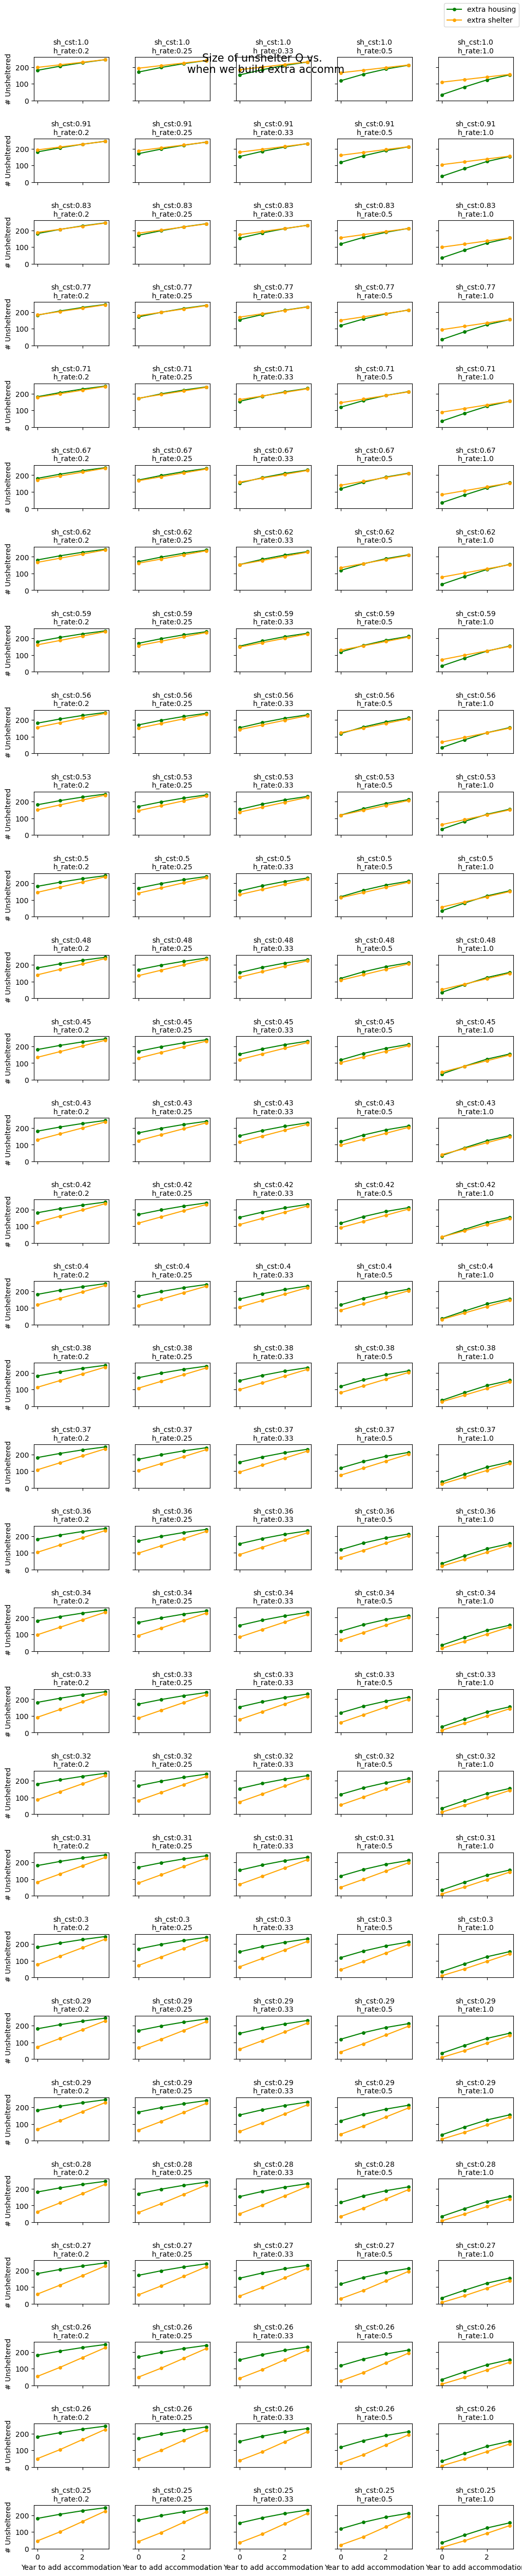

In [13]:
title1 = 'sh_cst:'
title2 = 'h_rate:'
x = [0,1,2,3]
n_rw = len(additional_shelter)
n_cl = len(service_times)
fig, axs = plt.subplots(n_rw, n_cl,  figsize=(10, 50))
for i in range(n_rw):
    for j in range(n_cl):
        line1, = axs[i, j].plot(x, housing_imprv_all1_obj1[i][n_cl -1 - j], color = 'green', label = 'extra housing', marker='o', markersize = 4)
        line2, = axs[i, j].plot(x, shelter_imprv_all1_obj1[i][n_cl -1 - j], color = 'orange', label = 'extra shelter', marker='o', markersize = 4)
        axs[i, j].set_title(title1 + 
                            str(round(hx/(additional_shelter[i]),2)) + 
                            '\n' + 
                            title2 + 
                            str(round(1/service_times[n_cl -1 - j],2)), fontsize = 10)
        axs[i, j].set_ylim(0,260)

plt.suptitle('Size of unshelter Q vs. \n when we build extra accomm', fontsize = 15)            
fig.legend(handles=[line1, line2]) 
fig.tight_layout()
            
for ax in axs.flat:
    ax.set(xlabel='Year to add accommodation', ylabel='# Unsheltered')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

#### What do we know?

Assumming an objective function of the expected value of the time average of the size of the unsheltered Q:
* If we add accomm later, the objective func. value for the full time horizon will increase
* When housing/shelter cost the same, extra housing is always better than extra shelter, because it takes someone out of the unsheltered and increases the overall rate at which people leave the system. 
    * The amount by which we prefer extra housing decreases if you add it later
* When we reduce cost of shelter, the obj value for adding extra shelter decreases until we eventually prefer shelter. The 'shelter cost' at which this crossover (in preference) occurs is different for the different years of the model run, starting with later years. This makes sense because in later years, the benefit of extra housing is less than in earlier years, because there is less time for the benefit to take effect, so in later years, shelter has to only be a little bit cheaper for us to be able to afford enough to make it preferable to housing. As we slowly reduce the cost of shelter, while the crossover in preference takes place, we have solution spaces which indicate an initial preference for housing, followed by a preference for housing. 
* The 'crossover' occurs at a cheaper 'shelter cost' when the housing service rate is increased. 
* When we keep the cost of shelter the same and increase the service rate at housing, we see the effect that the objective value for adding extra shelter decreases, but it decreases more for adding extra housing. However, this effect only holds for when the queue is sufficiently large. 
* When housing is doing much better than shelter, or when they are doing similarly well, adding extra housing gets worse more 'quickly' - i.e. the benefit you get as a result of increasing the overall rate of leaving system is more sensitive to changing the time at which you add it. If shelter is doing much better (when its much cheaper) - adding extra shelter gets worse more quickly. 
* Ultimately - if you leave it right to the last minute, assuming shelter is cheaper, shelter will always be preferable (but not by much), because there is little time for the benefit of housing to have an effect (and the benefit of extra shelter has little time to be much better) so if housing starts off being better, we can end up with a mixed optimal (i.e. first better to have housing, then better to have shelter). 

* First main thing: lose the value of adding housing more quickly than losing value of adding shelter, if you wait. if housing is initially better or if they are initially similar in performance. The second derivative (of the obj function, w.r.t. the time of adding the accommodation) is always smaller for housing (i.e. the obj function gets flatter quicker). 
* Second main thing: assuming cost of shelter is less, the difference between the two solutions (at any given point of adding the accommodation) is the difference between the extra shelter you get for your buck, as a result of it being cheaper, vs. the adding throughupt through the sytem you get as a result of having housing (processing people) instead of shelter. 

#### What happens if we increase the model run time, but not the times at which decisions are made

The latter point above should not be the case in reality, because having a house will have benefits which stretch longer than just the time at which the decision is made. So we can try modelling the system for 10 years, but only making decisions about the first 4 yrs. 

In [14]:
# Opening JSON file
with open('data_10yr.json') as json_file:
    data_10yr = json.load(json_file)

In [ ]:
# Explore range of shelter costs and service time distributions
print('start at time ' + str(datetime.datetime.now()))

b = 12 # baseline amount of house builds
hx = 60 # baseline extra house units
s = 12 # baseline amount of shelters to add you can get for the price of 12 housing

yrs_dec = 4 # decision space years

additional_shelter = [hx + 6*i for i in range(31)]
service_times = [1,2,3,4,5]

housing_imprv_all2_obj1 = [[] for i in range(len(additional_shelter))]
shelter_imprv_all2_obj1 = [[] for i in range(len(additional_shelter))]
housing_imprv_all2_obj2 = [[] for i in range(len(additional_shelter))]
shelter_imprv_all2_obj2 = [[] for i in range(len(additional_shelter))]
housing_imprv_all2_obj3 = [[] for i in range(len(additional_shelter))]
shelter_imprv_all2_obj3 = [[] for i in range(len(additional_shelter))]

for i in range(len(additional_shelter)):
    sx = additional_shelter[i]
    for j in range(len(service_times)):
        sols = [{'housing': [b+hx, b, b, b], 'shelter': [s, s, s, s]},
                {'housing': [b, b+hx, b, b], 'shelter': [s, s, s, s]},
                {'housing': [b, b, b+hx, b], 'shelter': [s, s, s, s]},
                {'housing': [b, b, b, b+hx], 'shelter': [s, s, s, s]},
                {'housing': [b, b, b, b], 'shelter': [s+sx, s, s, s]},
                {'housing': [b, b, b, b], 'shelter': [s, s+sx, s, s]},
                {'housing': [b, b, b, b], 'shelter': [s, s, s+sx, s]},
                {'housing': [b, b, b, b], 'shelter': [s, s, s, s+sx]}]
        # expand solution space
        sols = [{'housing' : sols[k]['housing']+[b for l in range(data_10yr['analysis_horizon'] - yrs_dec)],
                 'shelter' : sols[k]['shelter']+[s for l in range(data_10yr['analysis_horizon'] - yrs_dec)]} for k in range(len(sols))]
        spc = rs.SolutionSpace(sols)
        spc.model_analytically(data_10yr, data_as_is_analytical, data_10yr['analysis_horizon'], float(service_times[j]))
        
        housing_imprv1 = []
        shelter_imprv1 = []
        housing_imprv2 = []
        shelter_imprv2 = []
        housing_imprv3 = []
        shelter_imprv3 = []
        
        for k in range(yrs_dec):
            imprv = spc.true_outputs_unsh[k]
            housing_imprv1.append(imprv)
            imprv = spc.true_outputs_unsh[k+4]
            shelter_imprv1.append(imprv)
            # ----
            imprv = spc.true_outputs_unsh[k] + 0.5 * spc.true_outputs_sh[k]
            housing_imprv2.append(imprv)
            imprv = spc.true_outputs_unsh[k+4] + 0.5 * spc.true_outputs_sh[k+4]
            shelter_imprv2.append(imprv)            
            # ----
            imprv = (spc.true_outputs_unsh[k]**2) + 0.5 * (spc.true_outputs_sh[k]**2)
            housing_imprv3.append(imprv)
            imprv = (spc.true_outputs_unsh[k+4]**2) + 0.5 * (spc.true_outputs_sh[k+4]**2)
            shelter_imprv3.append(imprv)
        
        housing_imprv_all2_obj1[i].append(housing_imprv1)
        shelter_imprv_all2_obj1[i].append(shelter_imprv1)
        housing_imprv_all2_obj2[i].append(housing_imprv2)
        shelter_imprv_all2_obj2[i].append(shelter_imprv2) 
        housing_imprv_all2_obj3[i].append(housing_imprv3)
        shelter_imprv_all2_obj3[i].append(shelter_imprv3) 
        
        # print('done (' + str(i) + ', ' + str(j) + ')' + ' at time ' + str(datetime.datetime.now()))

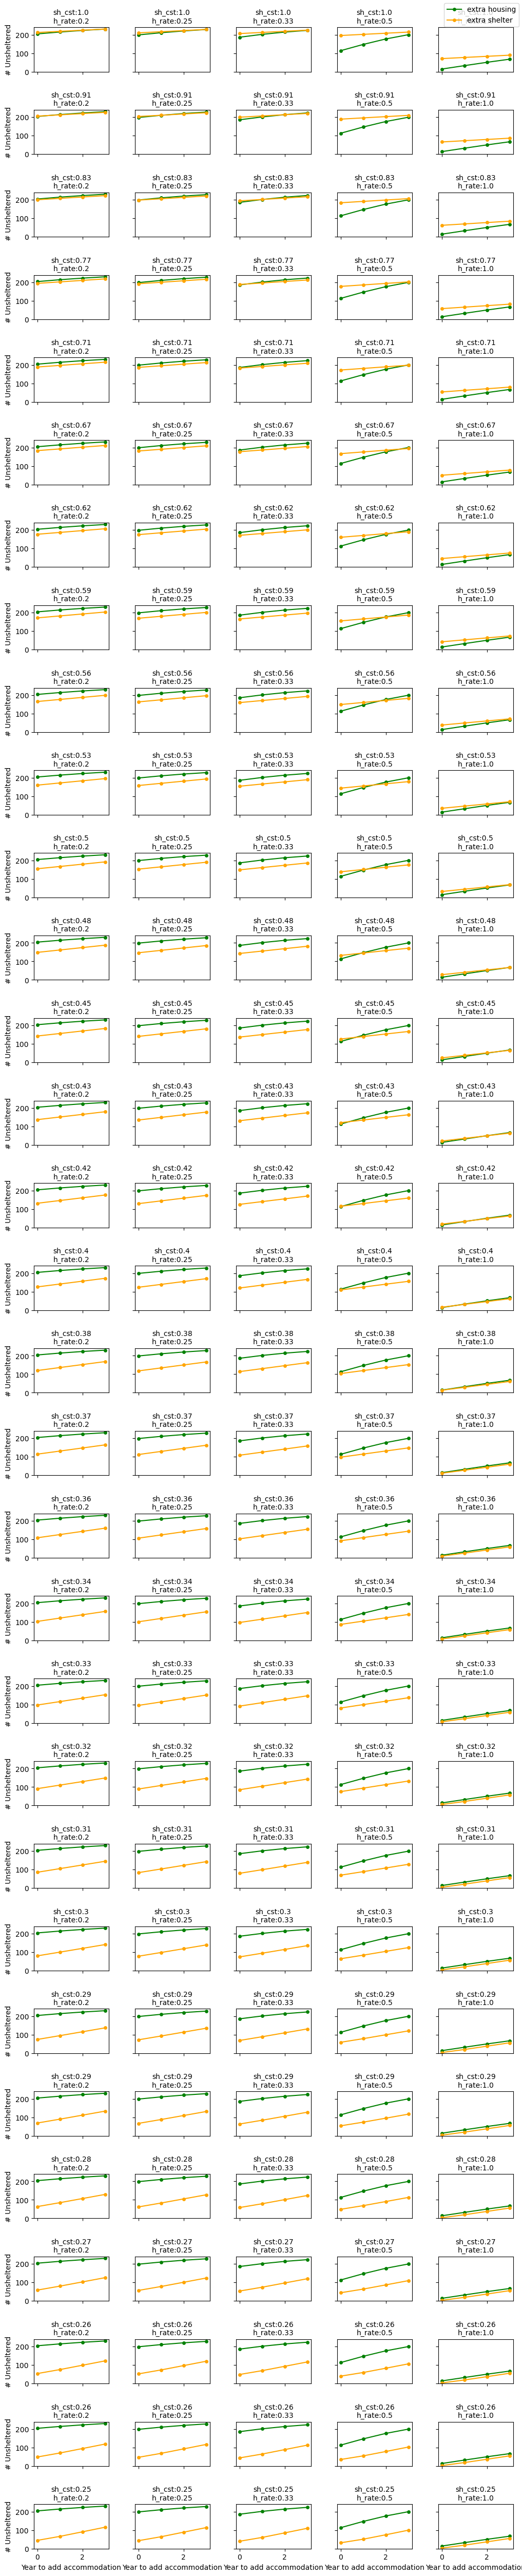

In [16]:
title1 = 'sh_cst:'
title2 = 'h_rate:'
x = [0,1,2,3]
n_rw = len(additional_shelter)
n_cl = len(service_times)
fig, axs = plt.subplots(n_rw, n_cl,  figsize=(10, 50))
for i in range(n_rw):
    for j in range(n_cl):
        line1, = axs[i, j].plot(x, housing_imprv_all2_obj1[i][n_cl -1 - j], color = 'green', label = 'extra housing', marker='o', markersize = 4)
        line2, = axs[i, j].plot(x, shelter_imprv_all2_obj1[i][n_cl -1 - j], color = 'orange', label = 'extra shelter', marker='o', markersize = 4)
        axs[i, j].set_title(title1 + 
                            str(round(hx/(additional_shelter[i]),2)) + 
                            '\n' + 
                            title2 + 
                            str(round(1/service_times[n_cl -1 - j],2)), fontsize = 10)
        axs[i, j].set_ylim(0,240)

#plt.suptitle('Size of unshelter Q vs. \n when we build extra accomm', fontsize = 15)            
fig.legend(handles=[line1, line2]) 
fig.tight_layout()
            
for ax in axs.flat:
    ax.set(xlabel='Year to add accommodation', ylabel='# Unsheltered')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

Comparing the same results for when we run the model for 4 yrs vs 10 yrs:

The headline stories are pretty much the same - even if the absolute values of the objective functions have changed. Those changes in the absolute values of the objective function do depend on the housing service rate because when this is high, the overall queue sizes can be getting smaller between 4 and 10 yrs (reducing the obj function), but when the housing service rate is low, the overall queues are growing and growing between 4 and 10 yrs (increasing the obj function). 

The main headline difference is that ultimately (i.e. at the last decision point), it is not necessarily preferable to build shelter (as it was when running the model for four years, assuming shelter was cheaper than housing). If the housing service rate is sufficiently high, then our latest decision can still be housing, because its benefits can have effect between yrs 4 and 10.

Also - the obj functions to not converge to being very similar, because the effects of the last decision have time to play out. 

For exactly the same set up otherwise, the preference can change from shelter to housing (when the housing service rate is high) or from housing to shelter (when the housing service rate is low). Therefore prolonging the model run can slow down the crossover to prefering shelter (as you reduce the cost of shelter) if the housing  service rate is high, or speed up the crossover to prefering shelter (as you reduce the cost of shelter) if the housing service rate is low. 

The plots below help us to compare the results for when we run the model for 4 yrs (first row of plots) vs 10 yrs (second row of plots)

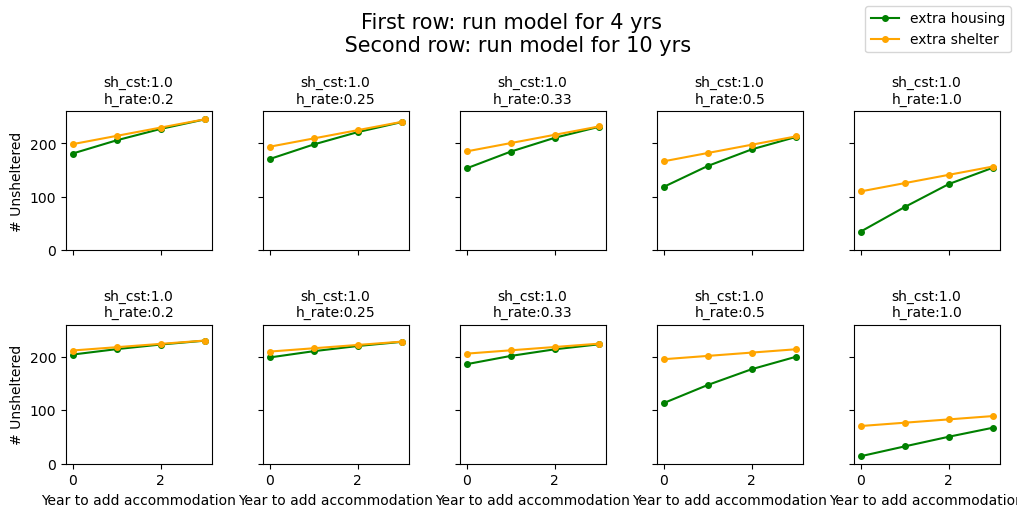

In [17]:
title1 = 'sh_cst:'
title2 = 'h_rate:'
x = [0,1,2,3]
n_rw = 2
n_cl = len(service_times)
fig, axs = plt.subplots(n_rw, n_cl,  figsize=(10, 5))
for j in range(n_cl):
    line1, = axs[0, j].plot(x, housing_imprv_all1_obj1[0][n_cl -1 - j], color = 'green', label = 'extra housing', marker='o', markersize = 4)
    line2, = axs[0, j].plot(x, shelter_imprv_all1_obj1[0][n_cl -1 - j], color = 'orange', label = 'extra shelter', marker='o', markersize = 4)
    axs[0, j].set_title(title1 + 
                        str(round(hx/(additional_shelter[0]),2)) + 
                        '\n' + 
                        title2 + 
                        str(round(1/service_times[n_cl -1 - j],2)), fontsize = 10)
    axs[0, j].set_ylim(0,260)

for j in range(n_cl):
    line1, = axs[1, j].plot(x, housing_imprv_all2_obj1[0][n_cl -1 - j], color = 'green', label = 'extra housing', marker='o', markersize = 4)
    line2, = axs[1, j].plot(x, shelter_imprv_all2_obj1[0][n_cl -1 - j], color = 'orange', label = 'extra shelter', marker='o', markersize = 4)
    axs[1, j].set_title(title1 + 
                        str(round(hx/(additional_shelter[0]),2)) + 
                        '\n' + 
                        title2 + 
                        str(round(1/service_times[n_cl -1 - j],2)), fontsize = 10)
    axs[1, j].set_ylim(0,260)    
    
plt.suptitle('First row: run model for 4 yrs \n Second row: run model for 10 yrs', fontsize = 15)            
fig.legend(handles=[line1, line2]) 
fig.tight_layout()
            
for ax in axs.flat:
    ax.set(xlabel='Year to add accommodation', ylabel='# Unsheltered')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

The data below illustrates the preference ('H' for housing or 'S' for shelter) in each year of the decision making process, so we can see how the change from a 4yr run to a 10 yr run impacts the preference. The results illustrate that when the housing svc rate is high, a preference for shelter can be switched to a preference for housing, and when the housing svc rate is low, a preference for housing can be swithced to a preference for shelter. 

In [18]:
for i in range(31):
    print('Shelter cost: ' + str(round(hx/(additional_shelter[i]),2)))
    for j in [4]:
        out_shrt = []
        out_long = []
        print('Housing rate: ' + str(1/service_times[5 -1 - j]))
        for k in range(4):
            if housing_imprv_all1_obj1[i][5-1-j][k] < shelter_imprv_all1_obj1[i][5-1-j][k]:
                out_shrt.append('H')
            else: 
                out_shrt.append('S')
            if housing_imprv_all2_obj1[i][5-1-j][k] < shelter_imprv_all2_obj1[i][5-1-j][k]:
                out_long.append('H')
            else: 
                out_long.append('S')
        print('04 yr run: ' + str(out_shrt))
        print('10 yr run: ' + str(out_long))
        
for i in range(31):
    print('Shelter cost: ' + str(round(hx/(additional_shelter[i]),2)))
    for j in [0]:
        out_shrt = []
        out_long = []
        print('Housing rate: ' + str(1/service_times[5 -1 - j]))
        for k in range(4):
            if housing_imprv_all1_obj1[i][5-1-j][k] < shelter_imprv_all1_obj1[i][5-1-j][k]:
                out_shrt.append('H')
            else: 
                out_shrt.append('S')
            if housing_imprv_all2_obj1[i][5-1-j][k] < shelter_imprv_all2_obj1[i][5-1-j][k]:
                out_long.append('H')
            else: 
                out_long.append('S')
        print('04 yr run: ' + str(out_shrt))
        print('10 yr run: ' + str(out_long))

Shelter cost: 1.0
Housing rate: 1.0
04 yr run: ['H', 'H', 'H', 'H']
10 yr run: ['H', 'H', 'H', 'H']
Shelter cost: 0.91
Housing rate: 1.0
04 yr run: ['H', 'H', 'H', 'H']
10 yr run: ['H', 'H', 'H', 'H']
Shelter cost: 0.83
Housing rate: 1.0
04 yr run: ['H', 'H', 'H', 'H']
10 yr run: ['H', 'H', 'H', 'H']
Shelter cost: 0.77
Housing rate: 1.0
04 yr run: ['H', 'H', 'H', 'H']
10 yr run: ['H', 'H', 'H', 'H']
Shelter cost: 0.71
Housing rate: 1.0
04 yr run: ['H', 'H', 'H', 'S']
10 yr run: ['H', 'H', 'H', 'H']
Shelter cost: 0.67
Housing rate: 1.0
04 yr run: ['H', 'H', 'H', 'S']
10 yr run: ['H', 'H', 'H', 'H']
Shelter cost: 0.62
Housing rate: 1.0
04 yr run: ['H', 'H', 'H', 'S']
10 yr run: ['H', 'H', 'H', 'H']
Shelter cost: 0.59
Housing rate: 1.0
04 yr run: ['H', 'H', 'H', 'S']
10 yr run: ['H', 'H', 'H', 'H']
Shelter cost: 0.56
Housing rate: 1.0
04 yr run: ['H', 'H', 'S', 'S']
10 yr run: ['H', 'H', 'H', 'H']
Shelter cost: 0.53
Housing rate: 1.0
04 yr run: ['H', 'H', 'S', 'S']
10 yr run: ['H', 'H', '

#### Look at the effect of changing the arrival rate function

Up until now we have had a constant arrival rate function, but we now look at different arrival rate functions. 

* Constant: low
* Constant: medium
* Constant: high

* Increasing: low to high
* Decreasing: high to low
* Spike: low to high to low
* Dip: high to low to high

We build on experiment 1 - where we do not let the model run for multiple years after decisions have been made. We change the arrival rate functions over the four year period in order to analyse the affect. 

Comment: we may need to think here about whether it is appropriate to model periods of time where there is 'stability' in the system - i.e. when the arrival rate is less than the service rate - because this introduces the possibility of empty queues and idle servers, which perhaps complicates the picture when we are looking at the objective function values, particularly when we are comparing the obj func values associated with building extra housing or extra shelter. 

In [19]:
data_as_is_exp3 = data_10yr.copy()

b = 12 # baseline amount of house builds
hx = 60 # baseline extra house units
s = 12 # baseline amount of shelters to add you can get for the price of 12 housing

yrs_dec = 4 # decision space years

additional_shelter = [hx + 90]
sx = additional_shelter[0]
service_times = [2]

initial_builds = data_as_is_exp3['initial_capacity']['housing'] # average number of housing units over time that are there initially
subsequent_builds_baseline = np.mean([b*i for i in range(1, data_as_is_exp3['analysis_horizon']+1)]) # average number of housing units over time given that we build 12 every year for duration
avg_over_time_for_each_build_house_option = [np.mean([hx for i in range(k+1)] + 
                                                     [0 for j in range(yrs_dec-(k+1))] + 
                                                     [hx for l in range(data_as_is_exp3['analysis_horizon']-yrs_dec)]) for k in range(yrs_dec)]
subsequent_builds_extra = np.mean(avg_over_time_for_each_build_house_option + [0,0,0,0])
avg_service_rate = (initial_builds+subsequent_builds_baseline+subsequent_builds_extra) * (1/service_times[0])
print('Average service rate (when running model for 10 yrs) is: ' + str(avg_service_rate))
max_service_rate = (initial_builds+b*data_as_is_exp3['analysis_horizon'] + 60) * (1/service_times[0])
print('Max service rate (when running model for 10 yrs) with avg service times of 3yrs: ' + str(max_service_rate))

Average service rate (when running model for 10 yrs) is: 65.75
Max service rate (when running model for 10 yrs) with avg service times of 3yrs: 110.0


Arrival rate functions are therefore set as below

In [20]:
arrival_rate_funcs = [[20 for i in range(10)],
                      [70 for i in range(10)],
                      [120 for i in range(10)],
                      [20 + (i+1)*10 for i in range(10)],
                      [120 - (i*10) for i in range(10)],
                      [20, 120, 120, 20] + [70 for i in range(6)],
                      [120, 20, 20, 120] + [70 for i in range(6)]]

arrival_rate_func_names = ['Const - low',
                          'Const - med',
                          'Const - high',
                          'Low to high',
                          'High to low',
                          'Initial spike (low to high to low)',
                          'Initial dip (high to low to high)']

for i in range(len(arrival_rate_funcs)):
    print(str(arrival_rate_func_names[i]) + ': ' + str(arrival_rate_funcs[i]))

Const - low: [20, 20, 20, 20, 20, 20, 20, 20, 20, 20]
Const - med: [70, 70, 70, 70, 70, 70, 70, 70, 70, 70]
Const - high: [120, 120, 120, 120, 120, 120, 120, 120, 120, 120]
Low to high: [30, 40, 50, 60, 70, 80, 90, 100, 110, 120]
High to low: [120, 110, 100, 90, 80, 70, 60, 50, 40, 30]
Initial spike (low to high to low): [20, 120, 120, 20, 70, 70, 70, 70, 70, 70]
Initial dip (high to low to high): [120, 20, 20, 120, 70, 70, 70, 70, 70, 70]


In [ ]:
# Explore range of shelter costs and service time distributions
print('start at time ' + str(datetime.datetime.now()))

housing_imprv_all3_obj1 = [[] for i in range(len(arrival_rate_funcs))]
shelter_imprv_all3_obj1 = [[] for i in range(len(arrival_rate_funcs))]

for i in range(len(arrival_rate_funcs)):
    sols = [{'housing': [b+hx, b, b, b], 'shelter': [s, s, s, s]},
            {'housing': [b, b+hx, b, b], 'shelter': [s, s, s, s]},
            {'housing': [b, b, b+hx, b], 'shelter': [s, s, s, s]},
            {'housing': [b, b, b, b+hx], 'shelter': [s, s, s, s]},
            {'housing': [b, b, b, b], 'shelter': [s+sx, s, s, s]},
            {'housing': [b, b, b, b], 'shelter': [s, s+sx, s, s]},
            {'housing': [b, b, b, b], 'shelter': [s, s, s+sx, s]},
            {'housing': [b, b, b, b], 'shelter': [s, s, s, s+sx]}]
    data_as_is_exp3['arrival_rates'] = arrival_rate_funcs[i]
    
    sols = [{'housing' : sols[k]['housing']+[b for l in range(data_10yr['analysis_horizon'] - yrs_dec)],
         'shelter' : sols[k]['shelter']+[s for l in range(data_10yr['analysis_horizon'] - yrs_dec)]} for k in range(len(sols))]

    
    spc = rs.SolutionSpace(sols)
    spc.model_analytically(data_as_is_exp3, 
                           data_as_is_analytical, 
                           data_as_is_exp3['analysis_horizon'], 
                           float(service_times[0]))

    housing_imprv1 = []
    shelter_imprv1 = []

    for k in range(yrs_dec):
        imprv = spc.true_outputs_unsh[k]
        housing_imprv1.append(imprv)
        imprv = spc.true_outputs_unsh[k+4]
        shelter_imprv1.append(imprv)

    housing_imprv_all3_obj1[i].append(housing_imprv1)
    shelter_imprv_all3_obj1[i].append(shelter_imprv1)

    # print('done (' + str(i) + ', ' + str(0) + ')' + ' at time ' + str(datetime.datetime.now()))

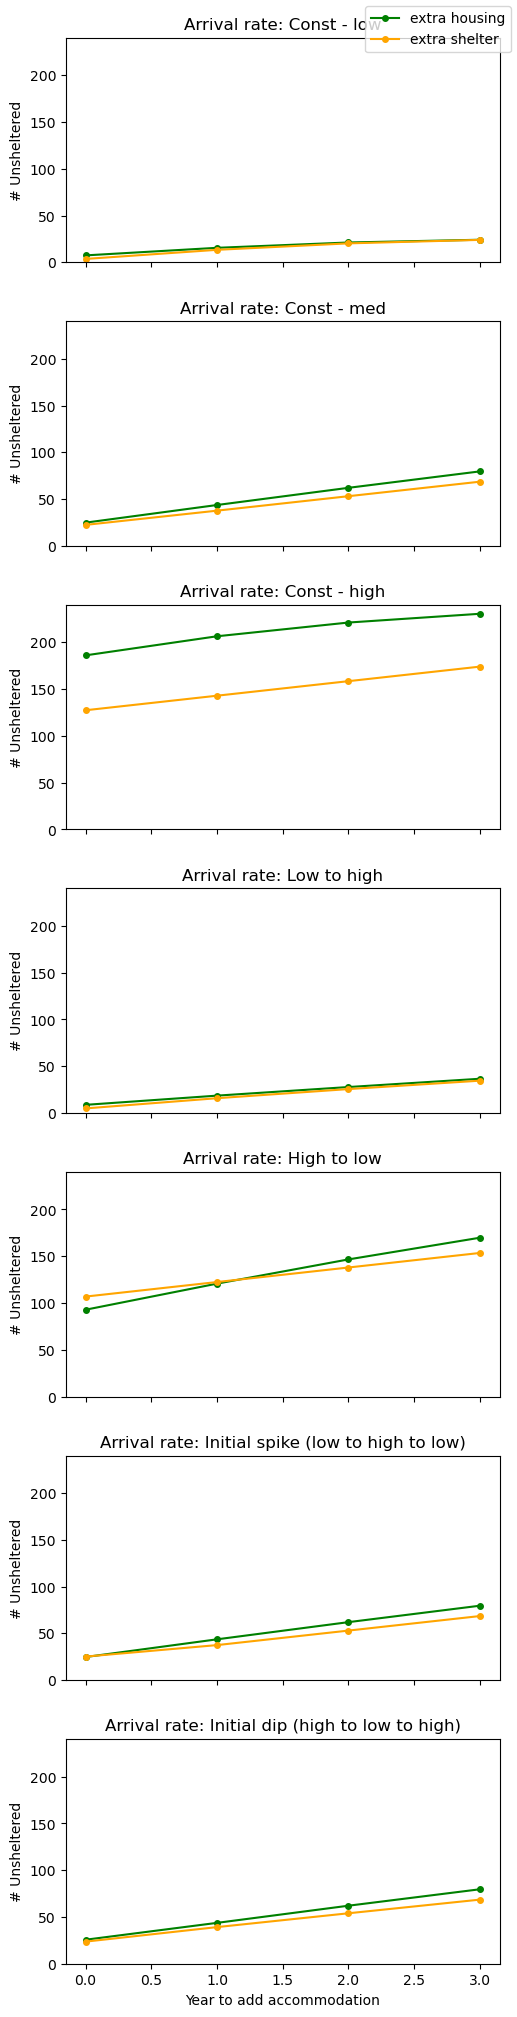

In [22]:
title = 'Arrival rate: '
x = [0,1,2,3]
n_cl = len(arrival_rate_funcs)
fig, axs = plt.subplots(n_cl, figsize=(5, 20))
for j in range(n_cl):
    line1, = axs[j].plot(x, housing_imprv_all3_obj1[j][0], color = 'green', label = 'extra housing', marker='o', markersize = 4)
    line2, = axs[j].plot(x, shelter_imprv_all3_obj1[j][0], color = 'orange', label = 'extra shelter', marker='o', markersize = 4)
    axs[j].set_title(title + arrival_rate_func_names[j])
    axs[j].set_ylim(0,240)

#plt.suptitle('Size of unshelter Q vs. \n when we build extra accomm', fontsize = 15)            
fig.legend(handles=[line1, line2]) 
fig.tight_layout()
            
for ax in axs.flat:
    ax.set(xlabel='Year to add accommodation', ylabel='# Unsheltered')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

When the arrival rate is low, we initially prefer shelter, but then this preference decreases at later time points. Similar story for a 'low to high' arrival rate, but a 'high to low' arrival rate starts with a preference for housing, followed by a preference for shelter. 

#### Two decisions

We now consider 2 decisions

In [ ]:
# Explore range of shelter costs and service time distributions
print('start at time ' + str(datetime.datetime.now()))

b = 12 # baseline amount of house builds
hx = 60 # baseline extra house units
s = 12 # baseline amount of shelters to add you can get for the price of 12 housing

yrs_dec = 4 # decision space years

additional_shelter = [hx + 6*i for i in range(21)]
service_times = [1,2,3,4,5]

housing_imprv_all4_obj1 = [[] for i in range(len(additional_shelter))]
shelter_imprv_all4_obj1 = [[] for i in range(len(additional_shelter))]
mixture_imprv_all4_obj1 = [[] for i in range(len(additional_shelter))]

for i in range(len(additional_shelter)):
    sx = additional_shelter[i]
    for j in range(len(service_times)):
        sols = [{'housing': [b+hx, b+hx, b, b], 'shelter': [s, s, s, s]},
                {'housing': [b+hx, b, b+hx, b], 'shelter': [s, s, s, s]},
                {'housing': [b+hx, b, b, b+hx], 'shelter': [s, s, s, s]},
                {'housing': [b, b+hx, b+hx, b], 'shelter': [s, s, s, s]},
                {'housing': [b, b+hx, b, b+hx], 'shelter': [s, s, s, s]},
                {'housing': [b, b, b+hx, b+hx], 'shelter': [s, s, s, s]},
                # ----
                {'housing': [b, b, b, b], 'shelter': [s+sx, s+sx, s, s]},
                {'housing': [b, b, b, b], 'shelter': [s+sx, s, s+sx, s]},
                {'housing': [b, b, b, b], 'shelter': [s+sx, s, s, s+sx]},
                {'housing': [b, b, b, b], 'shelter': [s, s+sx, s+sx, s]},
                {'housing': [b, b, b, b], 'shelter': [s, s+sx, s, s+sx]},
                {'housing': [b, b, b, b], 'shelter': [s, s, s+sx, s+sx]},
                # ----
                {'housing': [b+hx, b, b, b], 'shelter': [s, s+sx, s, s]},
                {'housing': [b+hx, b, b, b], 'shelter': [s, s, s+sx, s]},
                {'housing': [b+hx, b, b, b], 'shelter': [s, s, s, s+sx]},
                {'housing': [b, b+hx, b, b], 'shelter': [s+sx, s, s, s]},
                {'housing': [b, b+hx, b, b], 'shelter': [s, s, s+sx, s]},
                {'housing': [b, b+hx, b, b], 'shelter': [s, s, s, s+sx]},
                {'housing': [b, b, b+hx, b], 'shelter': [s+sx, s, s, s]},
                {'housing': [b, b, b+hx, b], 'shelter': [s, s+sx, s, s]},
                {'housing': [b, b, b+hx, b], 'shelter': [s, s, s, s+sx]},
                {'housing': [b, b, b, b+hx], 'shelter': [s+sx, s, s, s]},
                {'housing': [b, b, b, b+hx], 'shelter': [s, s+sx, s, s]},
                {'housing': [b, b, b, b+hx], 'shelter': [s, s, s+sx, s]}]
        # expand solution space
        sols = [{'housing' : sols[k]['housing']+[b for l in range(data_10yr['analysis_horizon'] - yrs_dec)],
                 'shelter' : sols[k]['shelter']+[s for l in range(data_10yr['analysis_horizon'] - yrs_dec)]} for k in range(len(sols))]
        spc = rs.SolutionSpace(sols)
        spc.model_analytically(data_10yr, data_as_is_analytical, data_10yr['analysis_horizon'], float(service_times[j]))
        
        housing_imprv1 = []
        shelter_imprv1 = []
        mixture_imprv1 = []
        
        for k in range(6):
            imprv = spc.true_outputs_unsh[k]
            housing_imprv1.append(imprv)
            imprv = spc.true_outputs_unsh[6+k]
            shelter_imprv1.append(imprv)
        for k in range(12):
            imprv = spc.true_outputs_unsh[12+k]
            mixture_imprv1.append(imprv)
        
        housing_imprv_all4_obj1[i].append(housing_imprv1)
        shelter_imprv_all4_obj1[i].append(shelter_imprv1)
        mixture_imprv_all4_obj1[i].append(mixture_imprv1)
        
        # print('done (' + str(i) + ', ' + str(j) + ')' + ' at time ' + str(datetime.datetime.now()))

In [24]:
a = [0,1,2,4,5,8]
b = [3,6,9,7,10,11]
comparisons_oneside = [[] for i in range(len(additional_shelter))]
comparisons_mixture = [[] for i in range(len(additional_shelter))]
for i in range(len(additional_shelter)):
    for j in range(len(service_times)):
        output_oneside = []
        for k in range(6):
            if housing_imprv_all4_obj1[i][j][k] < shelter_imprv_all4_obj1[i][j][k]:
                result = 'H'
            else: 
                result = 'S'
            output_oneside.append(result)
        output_mixture = []
        for k in range(6):
            result = mixture_imprv_all4_obj1[i][j][b[k]] - mixture_imprv_all4_obj1[i][j][a[k]]
            #if mixture_imprv_all4_obj1[i][j][a[k]] < mixture_imprv_all4_obj1[i][j][b[k]]:
            #    result = 'H'
            #elif mixture_imprv_all4_obj1[i][j][b[k]] < mixture_imprv_all4_obj1[i][j][a[k]]: 
            #    result = 'S'
            #else: 
            #    result = '-'
                
            output_mixture.append(result)
        comparisons_oneside[i].append(output_oneside)
        comparisons_mixture[i].append(output_mixture)
            

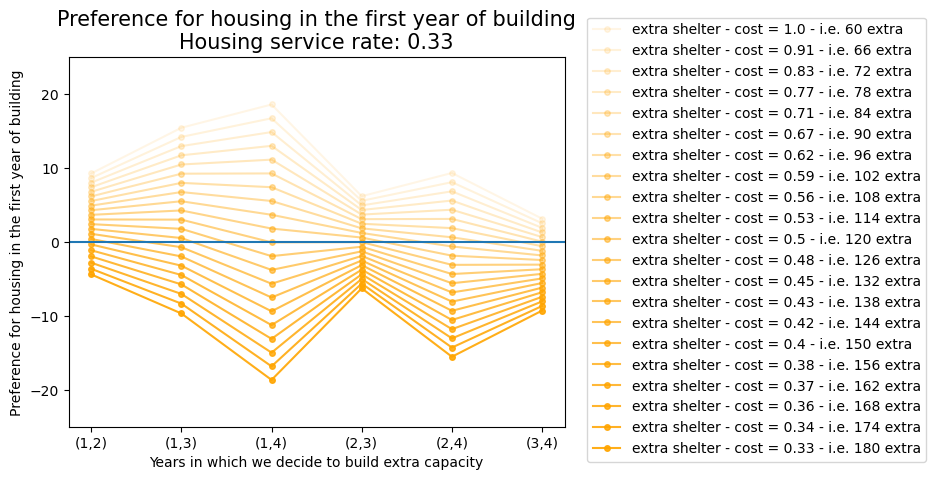

In [25]:
title2 = 'Housing service rate: '
x = [1,2,3,4,5,6]
x = ['(1,2)', '(1,3)', '(1,4)', '(2,3)', '(2,4)', '(3,4)']
fig, axs = plt.subplots()
for i in range(len(additional_shelter)):
    axs.plot(x, comparisons_mixture[i][2], color = 'orange', label = 'extra shelter - cost = ' + str(round(hx/(additional_shelter[i]),2)) + ' - i.e. ' + str(additional_shelter[i]) +  ' extra', marker='o', markersize = 4, alpha = (0.1 + i*0.04))
axs.set_ylim(-25,25)
fig.legend(bbox_to_anchor=(1.2,0.5), loc = 'center')
plt.xlabel('Years in which we decide to build extra capacity')
plt.ylabel('Preference for housing in the first year of building')
plt.title('Preference for housing in the first year of building' + '\n' +
          title2 + str(round(1/service_times[2],2)),fontsize = 15)
#axs.text(-1, 260, 'Figure 2')
plt.axhline(0)
plt.show()

When shelter is not so cheap, and when we must build extra shelter one year and extra housing in another year, we prefer to first building housing. Our preference is most when the builds are far apart in time. But as shelter gets cheaper, we have start having the preference for first building shelter. 